# HRV-Stress_machine-learning

## imbalance corection and split

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import os.path as osp
import os
from collections import Counter
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import ClusterCentroids 

In [2]:
random_state = 0 # for reproducibility
test_size = 0.2 # 20% data as test data

In [31]:
folder_path = 'data/collective'
file_name = 'kmeans_reaction_time_penalized_minmax.csv'
folder_train = osp.join('data',file_name[:-4],'train')
folder_test = osp.join('data',file_name[:-4],'test')
folder_result = osp.join('data',file_name[:-4],'result')
for f in [folder_train, folder_test, folder_result]:
    if not osp.exists(f):
        os.makedirs(f)
var_names = ['mrr_60s', 'mhr_60s', 'sdrr_60s', 'sdhr_60s', 'cvrr_60s', 'rmsd_60s', 'prr20_60s', 'prr50_60s']
label_name = 'reaction_time'

In [4]:
df = pd.read_csv(osp.join(folder_path,file_name))

In [5]:
x_raw = df[var_names]
x_raw.head()

,mrr_60s,mhr_60s,sdrr_60s,sdhr_60s,cvrr_60s,rmsd_60s,prr20_60s,prr50_60s
0,0.400619,0.572105,0.328196,0.291144,0.267566,0.053234,0.308456,0.409420
1,0.402431,0.561818,0.279335,0.248993,0.195138,0.040226,0.267009,0.420859
2,0.381155,0.580298,0.255609,0.222233,0.173936,0.018960,0.216945,0.385077
3,0.353799,0.613410,0.255825,0.263398,0.191623,0.011046,0.166881,0.385077
4,0.397365,0.572718,0.287726,0.306434,0.210596,0.100096,0.216945,0.492422


In [6]:
y_raw = df[label_name]
y_raw.head()

0    1
1    1
2    0
3    0
4    1
Name: reaction_time, dtype: int64

In [8]:
print('Original dataset shape %s' % Counter(y_raw))

# under sampling
cc = ClusterCentroids(sampling_strategy='not minority', random_state=random_state, voting='hard')
x_res, y_res = cc.fit_resample(x_raw, y_raw)

# # over sampling
# smt = SMOTETomek(random_state=random_state)
# x_res, y_res = smt.fit_resample(x_raw, y_raw)

print('Resampled dataset shape %s' % Counter(y_res))

# drop value outside scaler minmax range
x_res[label_name]=y_res
for var_name in var_names:
    x_res.drop(x_res[x_res[var_name] < 0].index, inplace = True)
    x_res.drop(x_res[x_res[var_name] > 1].index, inplace = True)

y_res = x_res[label_name]
x_res.drop(label_name, axis=1, inplace=True) 
print('Resampled dataset shape after minmax filter %s' % Counter(y_res))

Original dataset shape Counter({0: 23653, 1: 10144, 2: 3164, 3: 713})
Resampled dataset shape Counter({0: 713, 1: 713, 2: 713, 3: 713})
Resampled dataset shape after minmax filter Counter({0: 713, 1: 713, 2: 712, 3: 709})


In [9]:
x_res.head()

,mrr_60s,mhr_60s,sdrr_60s,sdhr_60s,cvrr_60s,rmsd_60s,prr20_60s,prr50_60s
0,0.346648,0.669590,0.794539,0.857568,0.851693,0.622087,0.625392,0.716758
1,0.315355,0.666753,0.517797,0.642479,0.553356,0.377795,0.447904,0.323187
2,0.683410,0.287325,0.275716,0.315094,0.278670,0.365968,0.525025,0.372709
3,0.851336,0.145133,0.519957,0.501667,0.423946,0.417692,0.708235,0.536853
4,0.257910,0.713305,0.374864,0.406878,0.491471,0.409692,0.517493,0.548226


In [10]:
x_train, x_test, y_train, y_test = train_test_split(x_res,y_res, test_size=test_size, random_state=random_state)
x_train.to_csv(osp.join(folder_train,'x_train_cc_res.csv'),index=False)
y_train.to_csv(osp.join(folder_train,'y_train_cc_res.csv'),index=False)
x_test.to_csv(osp.join(folder_test,'x_test_cc_res.csv'),index=False)
y_test.to_csv(osp.join(folder_test,'y_test_cc_res.csv'),index=False)

## evaluation function

In [11]:
from pprint import pprint

In [12]:
from sklearn.metrics import r2_score, accuracy_score
import numpy as np

def evaluate(y_true, y_predict, complete=False):
    accuracy = accuracy_score(y_true, y_predict)
    if complete:
        n = len(y_true)
        errors = abs(y_predict - y_true)
        mean_absolute_error = sum(errors) / n
        mean_squared_error = sum(np.power(errors,2)) / n
        root_mean_squared_error = np.sqrt(mean_squared_error)
        mean_absolute_percentage_error = sum(errors / y_true) / n
        accuracy_mape =  1 - mean_absolute_percentage_error
        r_square = r2_score(y_true, y_predict)

        return {
            'mean_absolute_error': mean_absolute_error,
            'mean_squared_error': mean_squared_error,
            'root_mean_squared_error': root_mean_squared_error,
            'mean_absolute_percentage_error': mean_absolute_percentage_error,
            'accuracy mape': accuracy_mape,
            'accuracy': accuracy,
            'r_square': r_square
        }
    else:
        return {
            'accuracy': accuracy,
        }

In [13]:
from sklearn.svm import SVC
# svc = SVC(kernel='rbf', decision_function_shape='ovo', random_state=random_state)
# svc.fit(x_train, y_train)
# y_predict = svc.predict(x_test)
# accuracy = evaluate(y_test, y_predict)
# pprint(accuracy)

In [14]:
from sklearn.neighbors import KNeighborsClassifier
# knn = KNeighborsClassifier(n_neighbors=10)
# knn.fit(x_train, y_train)
# y_predict = knn.predict(x_test)
# accuracy = evaluate(y_test, y_predict)
# pprint(accuracy)

In [15]:
from sklearn.neural_network import MLPClassifier
# ann = MLPClassifier(solver='adam', hidden_layer_sizes=(20, 20), activation='relu', random_state=random_state, max_iter=2000)
# ann.fit(x_train, y_train)
# y_predict = ann.predict(x_test)
# accuracy = evaluate(y_test, y_predict)
# pprint(accuracy)

## grid search

In [16]:
from sklearn.model_selection import GridSearchCV

In [17]:
# # Create the parameter grid based on the results of random search 
# param_grid_svc = {
#     'decision_function_shape': ['ovo', 'ovr'],
#     'kernel': ['linear', 'poly', 'rbf'],
#     'degree': [3],
#     'gamma': ['scale'],
#     'probability'=[True]
# }
# svc = SVC()

# # Instantiate the grid search model
# grid_svc = GridSearchCV(estimator = svc, param_grid = param_grid_svc, cv = 5, n_jobs = -1)

# # Fit the grid search to the data
# grid_svc.fit(x_train, y_train)
# svc_best_params = grid_svc.best_params_
# pprint(svc_best_params)

# svc = SVC(**svc_best_params, random_state=random_state)
# svc.fit(x_train, y_train)
# y_predict = svc.predict(x_test)
# accuracy = evaluate(y_test, y_predict)
# pprint(accuracy)

# # # result
# # {'decision_function_shape': 'ovo',
# #  'degree': 3,
# #  'gamma': 'scale',
# #  'kernel': 'linear'}
# # {'accuracy': 0.49007444168734493}
svc_best_params = {
    'decision_function_shape': 'ovo',
    'degree': 3,
    'gamma': 'scale',
    'kernel': 'linear',
    'probability':True
}
svc = SVC(**svc_best_params, random_state=random_state)

In [18]:
# # Create the parameter grid based on the results of random search 
# param_grid_knn = {
#     'n_neighbors': [3, 15, 27, 39, 51, 63, 75, 87, 99]
# }

# knn = KNeighborsClassifier()
# # Instantiate the grid search model
# grid_knn = GridSearchCV(estimator = knn, param_grid = param_grid_knn, cv = 5, n_jobs = -1)

# # Fit the grid search to the data
# grid_knn.fit(x_train, y_train)
# knn_best_params = grid_knn.best_params_
# pprint(knn_best_params)

# knn = KNeighborsClassifier(**knn_best_params)
# knn.fit(x_train, y_train)
# y_predict = knn.predict(x_test)
# accuracy = evaluate(y_test, y_predict)
# pprint(accuracy)

# # # result
# # {'n_neighbors': 51}
# # {'accuracy': 0.4987593052109181}

knn_best_params = {
    'n_neighbors': 51
}
knn = KNeighborsClassifier(**knn_best_params)

In [19]:
# # Create the parameter grid based on the results of random search 
# param_grid_ann = {
#     'solver': ['lbfgs', 'sgd', 'adam'],
#     'activation': ['identity', 'logistic', 'tanh', 'relu'],
#     'hidden_layer_sizes': [(10, 10), (20, 20), (20, 10), (10, 20)],
#     'max_iter': [2000] 
# }
# ann = MLPClassifier()

# # Instantiate the grid search model
# grid_ann = GridSearchCV(estimator = ann, param_grid = param_grid_ann, cv = 5, n_jobs = -1, error_score=0)

# # Fit the grid search to the data
# grid_ann.fit(x_train, y_train)
# ann_best_params = grid_ann.best_params_
# pprint(ann_best_params)

# ann = MLPClassifier(**ann_best_params, random_state=random_state)
# ann.fit(x_train, y_train)
# y_predict = ann.predict(x_test)
# accuracy = evaluate(y_test, y_predict)
# pprint(accuracy)

# # # result
# # {'activation': 'relu',
# #  'hidden_layer_sizes': (10, 20),
# #  'max_iter': 2000,
# #  'solver': 'adam'}
# # {'accuracy': 0.5}

ann_best_params = {
    'activation': 'relu',
    'hidden_layer_sizes': (10, 20),
    'max_iter': 2000,
    'solver': 'adam'
}
ann = MLPClassifier(**ann_best_params, random_state=random_state)

## ensemble vs individual

In [20]:
import pickle
from sklearn.ensemble import VotingClassifier

In [21]:
ensemble_hard = VotingClassifier(estimators=[('svc', svc), ('knn', knn), ('ann', ann)], voting='hard')
ensemble_hard.fit(x_train, y_train)
y_predict = ensemble_hard.predict(x_test)
accuracy = evaluate(y_test, y_predict)
pprint(accuracy)

filename = 'ensemble_hard.pickle'
pickle.dump(ensemble_hard, open(osp.join(folder_result,filename), 'wb'))

{'accuracy': 0.2631578947368421}


In [22]:
ensemble_soft = VotingClassifier(estimators=[('svc', svc), ('knn', knn), ('ann', ann)], voting='soft')
ensemble_soft.fit(x_train, y_train)
y_predict = ensemble_soft.predict(x_test)
accuracy = evaluate(y_test, y_predict)
pprint(accuracy)

filename = 'ensemble_soft.pickle'
pickle.dump(ensemble_soft, open(osp.join(folder_result,filename), 'wb'))

{'accuracy': 0.2649122807017544}


In [23]:
svc.fit(x_train, y_train)
y_predict = svc.predict(x_test)
accuracy = evaluate(y_test, y_predict)
pprint(accuracy)

filename = 'svc.pickle'
pickle.dump(svc, open(osp.join(folder_result,filename), 'wb'))

knn.fit(x_train, y_train)
y_predict = knn.predict(x_test)
accuracy = evaluate(y_test, y_predict)
pprint(accuracy)

filename = 'knn.pickle'
pickle.dump(knn, open(osp.join(folder_result,filename), 'wb'))

ann.fit(x_train, y_train)
y_predict = ann.predict(x_test)
accuracy = evaluate(y_test, y_predict)
pprint(accuracy)

filename = 'ann.pickle'
pickle.dump(ann, open(osp.join(folder_result,filename), 'wb'))

{'accuracy': 0.24912280701754386}
{'accuracy': 0.2543859649122807}
{'accuracy': 0.24561403508771928}


## confusion matrix

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

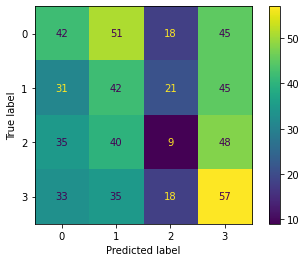

In [25]:
plot_confusion_matrix(ensemble_hard, x_test, y_test)  # doctest: +SKIP
plt.show()  # doctest: +SKIP

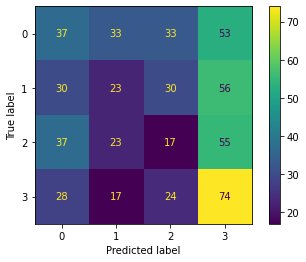

In [26]:
plot_confusion_matrix(ensemble_soft, x_test, y_test)  # doctest: +SKIP
plt.show()  # doctest: +SKIP

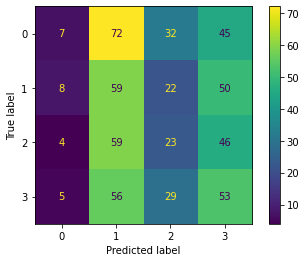

In [27]:
plot_confusion_matrix(svc, x_test, y_test)  # doctest: +SKIP
plt.show()  # doctest: +SKIP

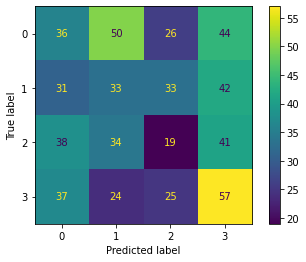

In [28]:
plot_confusion_matrix(knn, x_test, y_test)  # doctest: +SKIP
plt.show()  # doctest: +SKIP

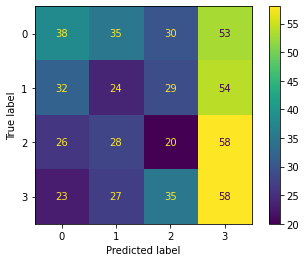

In [29]:
plot_confusion_matrix(ann, x_test, y_test)  # doctest: +SKIP
plt.show()  # doctest: +SKIP

## test on original data

In [33]:
x_ori_test = pd.read_csv(osp.join(folder_test,'x_test.csv'))
x_ori_test.head()

,mrr_60s,mhr_60s,sdrr_60s,sdhr_60s,cvrr_60s,rmsd_60s,prr20_60s,prr50_60s
0,0.810535,0.191905,0.232769,0.340887,0.220255,0.104629,0.214326,0.184139
1,0.160288,0.847732,0.350099,0.347557,0.490402,0.324163,0.219500,0.283961
2,0.502371,0.466091,0.719579,0.717535,0.827895,0.501121,0.778710,0.459461
3,0.823571,0.132086,0.762655,0.545665,0.470358,0.743121,0.481907,0.731085
4,0.539154,0.344912,0.429476,0.470999,0.393030,0.530836,0.590579,0.678343


In [34]:
y_ori_test = pd.read_csv(osp.join(folder_test,'y_test.csv'))
y_ori_test.head()

,reaction_time
0,0
1,1
2,1
3,2
4,0


{'accuracy': 0.2836098208360982}


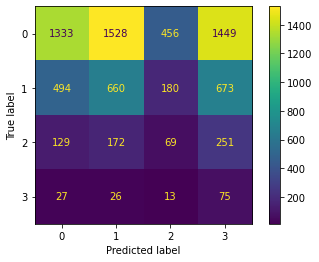

In [40]:
y_predict = ensemble_hard.predict(x_ori_test)
accuracy = evaluate(y_ori_test, y_predict)
pprint(accuracy)
plot_confusion_matrix(ensemble_hard, x_ori_test, y_ori_test)  # doctest: +SKIP
plt.show()  # doctest: +SKIP

{'accuracy': 0.2593231585932316}


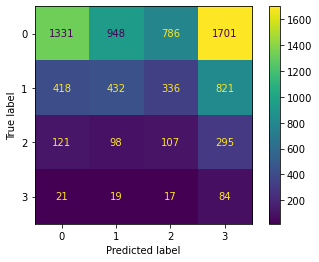

In [41]:
y_predict = ensemble_soft.predict(x_ori_test)
accuracy = evaluate(y_ori_test, y_predict)
pprint(accuracy)
plot_confusion_matrix(ensemble_soft, x_ori_test, y_ori_test)  # doctest: +SKIP
plt.show()  # doctest: +SKIP

{'accuracy': 0.17518248175182483}


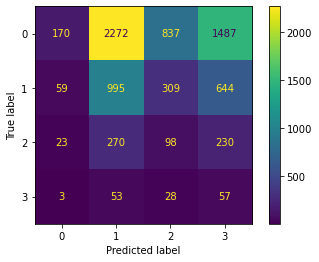

In [42]:
y_predict = svc.predict(x_ori_test)
accuracy = evaluate(y_ori_test, y_predict)
pprint(accuracy)
plot_confusion_matrix(svc, x_ori_test, y_ori_test)  # doctest: +SKIP
plt.show()  # doctest: +SKIP

{'accuracy': 0.2798938287989383}


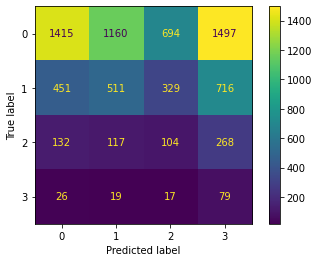

In [43]:
y_predict = knn.predict(x_ori_test)
accuracy = evaluate(y_ori_test, y_predict)
pprint(accuracy)
plot_confusion_matrix(knn, x_ori_test, y_ori_test)  # doctest: +SKIP
plt.show()  # doctest: +SKIP

{'accuracy': 0.23596549435965494}


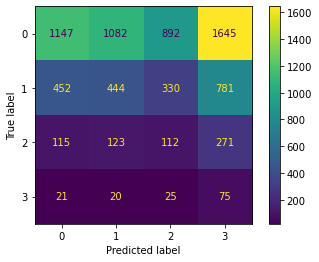

In [44]:
y_predict = ann.predict(x_ori_test)
accuracy = evaluate(y_ori_test, y_predict)
pprint(accuracy)
plot_confusion_matrix(ann, x_ori_test, y_ori_test)  # doctest: +SKIP
plt.show()  # doctest: +SKIP

## itterate variable

In [ ]:
def combinations(target,data):
    for i in range(len(data)):
        yield [*target, data[i]]
        yield from combinations([*target, data[i]], data[i+1:])

In [ ]:
label_name = 'reaction_time'
case_names = combinations([],var_names)
case_names = [case_name for case_name in case_names]

In [ ]:
# wrapper_svc = {}
# for case_name in case_names:
#     x_train_temp = x_train[case_name]
#     x_test_temp = x_test[case_name]
#     svc = SVC(**svc_best_params, random_state=random_state)
#     svc.fit(x_train_temp, y_train)
#     y_predict = svc.predict(x_test_temp)
#     accuracy = evaluate(y_test, y_predict)   
#     wrapper_svc[str(case_name)] = accuracy
#     print(f"{case_name}: {accuracy}")
    
# df_wrapper_svc = pd.DataFrame.from_dict(wrapper_svc, orient='index')
# df_wrapper_svc.to_csv(os.path.join(folder_result,'svc.csv'),index=True) 

In [ ]:
# wrapper_knn = {}
# for case_name in case_names:
#     x_train_temp = x_train[case_name]
#     x_test_temp = x_test[case_name]
#     knn = KNeighborsClassifier(**knn_best_params)
#     knn.fit(x_train_temp, y_train)
#     y_predict = knn.predict(x_test_temp)
#     accuracy = evaluate(y_test, y_predict)   
#     wrapper_knn[str(case_name)] = accuracy
#     print(f"{case_name}: {accuracy}")
    
# df_wrapper_knn = pd.DataFrame.from_dict(wrapper_knn, orient='index')
# df_wrapper_knn.to_csv(os.path.join(folder_result,'knn.csv'),index=True)

In [ ]:
# wrapper_ann = {}
# for case_name in case_names:
#     x_train_temp = x_train[case_name]
#     x_test_temp = x_test[case_name]
#     ann = MLPClassifier(**ann_best_params, random_state=random_state)
#     ann.fit(x_train_temp, y_train)
#     y_predict = ann.predict(x_test_temp)
#     accuracy = evaluate(y_test, y_predict)   
#     wrapper_ann[str(case_name)] = accuracy
#     print(f"{case_name}: {accuracy}")

# df_wrapper_ann = pd.DataFrame.from_dict(wrapper_ann, orient='index')
# df_wrapper_ann.to_csv(os.path.join(folder_result,'ann.csv'),index=True) 

In [ ]:
# wrapper_ensemble_hard = {}
# for case_name in case_names:
#     x_train_temp = x_train[case_name]
#     x_test_temp = x_test[case_name]
#     ensemble_hard = VotingClassifier(estimators=[('svc',svc),('knn',knn),('ann',ann)], voting='hard', n_jobs=-1)
#     ensemble_hard.fit(x_train_temp, y_train)
#     y_predict = ensemble_hard.predict(x_test_temp)
#     accuracy = evaluate(y_test, y_predict)    
#     wrapper_ensemble_hard[str(case_name)] = accuracy
#     print(f"{case_name}: {accuracy}")

# df_wrapper_ensemble_hard = pd.DataFrame.from_dict(wrapper_ensemble_hard, orient='index')
# df_wrapper_ensemble_hard.to_csv(os.path.join(folder_path,'ensemble_hard.csv'),index=True) 

In [ ]:
# wrapper_ensemble_soft = {}
# for case_name in case_names:
#     x_train_temp = x_train[case_name]
#     x_test_temp = x_test[case_name]
#     ensemble_soft = VotingClassifier(estimators=[('svc', svc),('knn',knn),('ann',ann)], voting='soft', n_jobs=-1)
#     ensemble_soft.fit(x_train_temp, y_train)
#     y_predict = ensemble_soft.predict(x_test_temp)
#     accuracy = evaluate(y_test, y_predict)    
#     wrapper_ensemble_soft[str(case_name)] = accuracy
#     print(f"{case_name}: {accuracy}")

# df_wrapper_ensemble_soft = pd.DataFrame.from_dict(wrapper_ensemble_soft, orient='index')
# df_wrapper_ensemble_soft.to_csv(os.path.join(folder_path,'ensemble_soft.csv'),index=True) 